In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df_selected = pd.read_csv('rusentiment_preselected_posts.csv')
df_random = pd.read_csv('rusentiment_random_posts.csv')
df_test = pd.read_csv('rusentiment_test.csv')

In [10]:
df_train = pd.concat((df_selected, df_random))

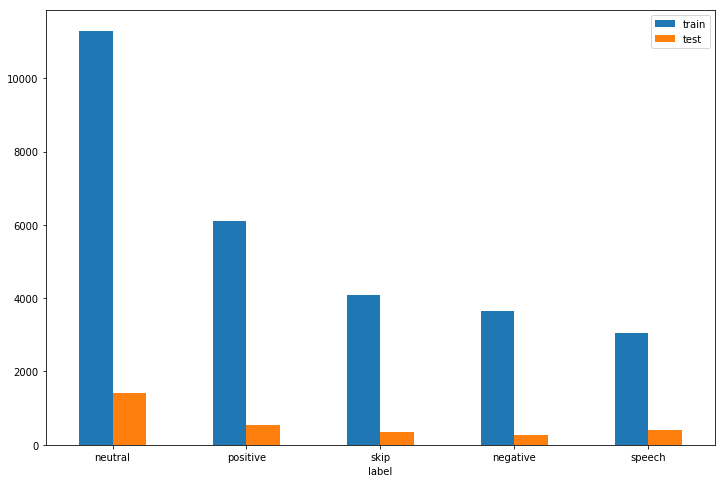

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'train': df_train.groupby('label').text.count(), 'test':df_test.groupby('label').text.count()})
freq.sort_values(by='train', ascending=False).plot.bar(rot=0, ax=ax);

In [12]:
# Original code https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py
from ufal.udpipe import Model, Pipeline

#! wget http://rusvectores.org/static/models/udpipe_syntagrus.model
udpipe_filename = 'udpipe_syntagrus.model'
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

def tag_ud(pipeline, text='Text in string format', pos=True):
    # если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста лемму и тэг
    tagged = [w.split('\t')[2].lower() + '_' + w.split('\t')[3] for w in content if w]
    result = []
    for t in tagged:
        if (len(t.split('_')) == 2):
            lemma, tag = t.split('_')
            # убираем числительные и все знаки пунктуации кроме скобок
            if tag == 'NUM' or (tag == 'PUNCT' and lemma not in ['(', ')']):
                continue
            if pos:
                result.append(lemma + '_' + tag)
            else:
                result.append(lemma)
    return result

In [13]:
df_train['lemmatized_tokens'] = df_train.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)
df_test['lemmatized_tokens'] = df_test.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)

df_train['lemmatized_text'] = df_train['lemmatized_tokens'].str.join(' ')
df_test['lemmatized_text'] = df_test['lemmatized_tokens'].str.join(' ')

df_train = df_train[~df_train.lemmatized_text.isnull()]
df_test = df_test[~df_test.lemmatized_text.isnull()]

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_train = df_train['lemmatized_text'].values
X_test = df_test['lemmatized_text'].values

y_train  = le.fit_transform(df_train['label'].values)
y_test  = le.transform(df_test['label'].values) 

array(['прорвем информационный блокада изнутри',
       'никогда у я не быть один приложение для все в топка этот ущербный универсальность',
       'кури-ь ты не укусить злой собака потому что ты вонять ,кури-ь ты не ограбить ,так как ты испугать грабитель отвратительный громкий кашель курить и ты не умирать от старость просто не дожить до она дама и господин курить насмерть',
       ...,
       'ур золото давать бесплатно написать это в комментарий и идти к саша или маша выбрать сколько надо и это правда',
       'с праздник ксюнь женский счастье ты выбирать любой',
       'международный марафон эрго белый ночь дистанция кмя из ( чистый время ) ) ) ) ) ) ) для я отличный результат ) )'],
      dtype=object)

In [16]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import expon

skf = StratifiedKFold(n_splits=5, random_state=42)
pipe = Pipeline([('tfidf',TfidfVectorizer(sublinear_tf=True)), ('classifier', MultinomialNB())])
param_grid = [
              {'classifier':[LogisticRegression(penalty='l1', dual=False)],
               'tfidf__ngram_range':[(1,1),(1,2)],
               'classifier__C': expon(scale=5).rvs(size=5)}, 
              {'classifier':[MultinomialNB(fit_prior=True,class_prior=None)],
              'tfidf__ngram_range':[(1,1),(1,2)],
              'tfidf__min_df':np.arange(3,6,1),
              'classifier__alpha': expon(scale=1).rvs(size=3), 
              },
              { 'classifier':[LinearSVC(penalty='l1', dual=False)],
                'tfidf__ngram_range':[(1,1),(1,2)],
               'classifier__C': expon(scale=2).rvs(size=4)
              }]

gr = GridSearchCV(pipe, param_grid, cv=skf, verbose=0, n_jobs=-1)
gr_model = gr.fit(X_train, y_train)


gr_model.best_params_, gr_model.best_score_

/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 8.07 s, sys: 501 ms, total: 8.57 s
Wall time: 2h 10min 8s


In [84]:
result = gr_model.cv_results_

In [85]:
rows = list ()
for model in result['params']:
    row = []
    for key, val in model.items():
        if key=='classifier':
            v_str = (val.__str__())
            row.append(v_str [ : v_str.find('(')])
        else:
            param = key.__str__()
            param = param [ param.find('__')+2 :]
            row.append(param + ' = ' + val.__str__())
    rows.append(row)

df = pd.DataFrame(rows)
df['score'] = result['mean_test_score']
df['time'] = result['mean_fit_time']

df = df.sort_values(by=['score'], ascending=False)
df

,0,1,2,3,score,time
0,LogisticRegression,C = 2.6644453551636724,"ngram_range = (1, 1)",None,0.596428,3.253181
1,LogisticRegression,C = 2.6644453551636724,"ngram_range = (1, 2)",None,0.594550,8.899513
35,LinearSVC,C = 1.407318441083937,"ngram_range = (1, 2)",None,0.588596,15.185530
31,LinearSVC,C = 1.3888592741266443,"ngram_range = (1, 2)",None,0.588348,13.758476
5,LogisticRegression,C = 5.726735875556365,"ngram_range = (1, 2)",None,0.587604,1814.452355
7,LogisticRegression,C = 5.838138457911631,"ngram_range = (1, 2)",None,0.586895,1913.270982
8,LogisticRegression,C = 1.0037062124097704,"ngram_range = (1, 1)",None,0.586328,4.083070
30,LinearSVC,C = 1.3888592741266443,"ngram_range = (1, 1)",None,0.584662,8.647488
34,LinearSVC,C = 1.407318441083937,"ngram_range = (1, 1)",None,0.583670,6.433576
4,LogisticRegression,C = 5.726735875556365,"ngram_range = (1, 1)",None,0.582961,1080.744147


Логистическая регрессия на оптимальных данных работает чуть лучше SVC (и при этом быстрее). Параметр ngram_range = (1, 2) почти не дает для нее улучшения score, но увеличивает время работы в разы. Если вместе с ngram_range = (1, 2) взять достаточно большой C (~6), то время обучения подскакивает на пару порядков. 

При оптимальных параметрах логистическая регрессия и SVC считаются гораздо быстрее, чем на неоптимальных (так что общее время работы еще можно оптимизировать). 35 комбинаций параметров просчитывались 2 часа 10 минут.
При этом время работы наивного Байеса не сильно менялось в зависимости от параметров (в среднем 5 секунд для ngram_range = (1, 2) и 2 секунды для ngram_range = (1, 1), выигрыш по score оказывается незначительным). Это говорит о стабильности алгоритма.

Наивный Байес при оптимальных параметрах всегда дает меньший score, чем логистическая регрессия и SVC, но может отработать быстрее их.

In [83]:
df.iloc[list([0,1,2,4,5,6,7,8,14,15,18,27,28])] #Более наглядная таблица работы классических моделей

,0,1,2,3,score,time
0,LogisticRegression,C = 2.6644453551636724,"ngram_range = (1, 1)",None,0.596428,3.253181
1,LogisticRegression,C = 2.6644453551636724,"ngram_range = (1, 2)",None,0.594550,8.899513
35,LinearSVC,C = 1.407318441083937,"ngram_range = (1, 2)",None,0.588596,15.185530
5,LogisticRegression,C = 5.726735875556365,"ngram_range = (1, 2)",None,0.587604,1814.452355
7,LogisticRegression,C = 5.838138457911631,"ngram_range = (1, 2)",None,0.586895,1913.270982
8,LogisticRegression,C = 1.0037062124097704,"ngram_range = (1, 1)",None,0.586328,4.083070
30,LinearSVC,C = 1.3888592741266443,"ngram_range = (1, 1)",None,0.584662,8.647488
34,LinearSVC,C = 1.407318441083937,"ngram_range = (1, 1)",None,0.583670,6.433576
25,MultinomialNB,alpha = 0.5414886666190056,min_df = 4,"ngram_range = (1, 2)",0.578780,5.057993
19,MultinomialNB,alpha = 0.546743819239456,min_df = 4,"ngram_range = (1, 2)",0.578638,5.040094


In [87]:
gr_model.best_params_, gr_model.best_score_

({'classifier': LogisticRegression(C=2.6644453551636724, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
            solver='warn', tol=0.0001, verbose=0, warm_start=False),
  'classifier__C': 2.6644453551636724,
  'tfidf__ngram_range': (1, 1)},
 0.5964278120348714)

In [88]:
best_pipe = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)),
                              ('lr', LogisticRegression(C=2.6644453551636724, penalty='l1', dual=False))])

In [89]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
def score_model(y_pred, y_true):
    average = 'weighted'
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

f1, precision, recall = score_model(y_pred,y_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1-score: {f1:.4f}')

/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Precision: 0.6662
Recall: 0.6822
f1-score: 0.6656


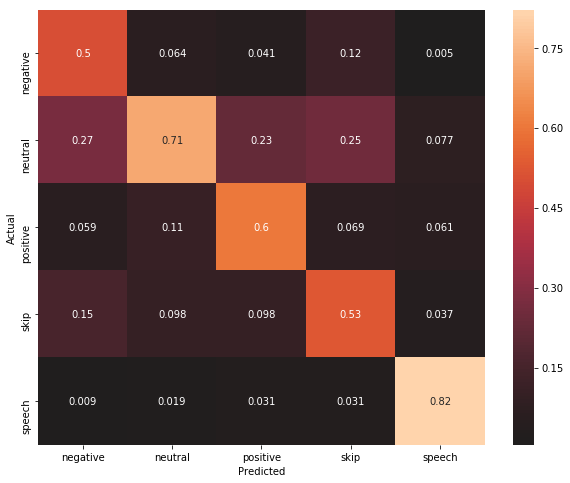

In [90]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_ratios = np.round(conf_mat / np.sum(conf_mat, axis=0),3)
fig, ax = plt.subplots(figsize=(10,8))

labels = sorted(list(set(le.inverse_transform(y_pred))))
sns.heatmap(conf_mat_ratios, annot=True, center=0, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [91]:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

results = pd.DataFrame({'text':df_test.text, 'lemmatized_tokens':df_test.lemmatized_tokens,'predicted':y_pred_labels, 'actual':y_test_labels})
errors = results[results.predicted != results.actual]

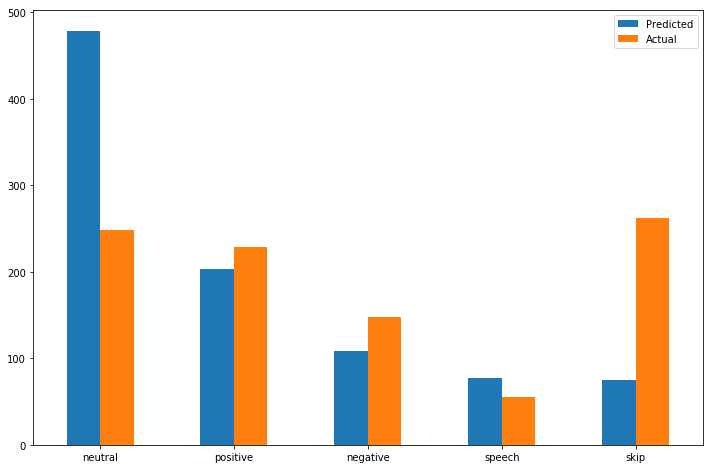

In [92]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'Predicted': errors.predicted.value_counts(), 'Actual':errors.actual.value_counts()})
freq.sort_values(by='Predicted', ascending=False).plot.bar(rot=0, ax=ax);

In [93]:
errors

,text,lemmatized_tokens,predicted,actual
3,Мы просто с [id12210212|Елисеем] психанули )...,"[мы, просто, с, id12210212|елисей, психануть, ...",positive,skip
11,Селфи дня )),"[селфи, день, ), )]",neutral,positive
17,"Я не писал такое оскобление всем!!!!\nМеня, ви...","[я, не, писать, такой, оскоблений, все, я, вид...",neutral,skip
18,...и так начало мини отпуска))И новых приключе...,"[...ь, так, начинать, минять, отпуск, ), ), и,...",neutral,positive
19,Кинул в чс обиделся холоп понял что недостоин ...,"[кидать, в, чс, обижаться, холоп, понимать, чт...",neutral,negative
21,Лучше бы у Тани не было никакого оргазма: услы...,"[хороший, бы, в, таня, не, быть, никакой, орга...",neutral,skip
25,"по кругу, твою подругу КСЮХУ....))))))ахахахаахах","[по, круг, твой, подруга, ксюх, ), ), ), ), ),...",neutral,skip
26,без тебя_(,"[без, (]",neutral,negative
27,я прыгнул в бездну из уюта пора готовиться к з...,"[я, прыгнуть, в, бездна, из, уют, пора, готови...",neutral,negative
29,"амммм, Каринка)))","[амммма, каринк, ), ), )]",neutral,skip
